In [1]:
# data munging and visualization
import numpy as np
import pandas as pd
import itertools

# class imbalance treatment
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

# feature engineering
import featuretools as ft

# predictor -> classification, regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import f1_score
import xgboost as xgb

# miscellanous
import datetime
import os

# external functions
import utils

# parallelization
from dask import bag
from dask.diagnostics import ProgressBar

/home/jo/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pbar = ProgressBar()
pbar.register()

## Iteration 1 (Unparallelized, find top features)

### Users entity

In [3]:
# sample_user_ratio = 20
user_details = pd.read_csv("data/users_1y_6mCustomerValue_3k.csv")
user_details['bux_account_created_dts'] = pd.to_datetime(user_details['bux_account_created_dts']) # format="%m/%d/%y %H:%M")
user_details['month_year'] = user_details['bux_account_created_dts'].apply(lambda x: x.strftime('%B-%Y'))
user_details.reset_index(drop=True,inplace=True)
user_details = user_details[user_details.columns[1:]]

user_details.reset_index(drop=True,inplace=True)
distinct_users = user_details["user_id"].unique()
user_details.head()

,user_id,country_cd,gender,nationality,platform_type_name,trading_experience,title,network,bux_account_created_dts,ams_first_funded_dts,initial_deposit_amount,trading_segment,month_year
0,001aabf1-ec53-44f9-a992-6f37060ff222,GB,NaN,NaN,Android,SOME,Experienced Trader,Appnext,2017-04-20 05:03:00.021,NaN,NaN,No Trades,April-2017
1,003ce8be-0875-447f-b2f4-7c105165b822,NL,NaN,NaN,Android,SOME,Experienced Trader,Organic,2017-06-19 19:36:24.204,NaN,NaN,No Trades,June-2017
2,00a7e0cf-824b-44f9-a7d5-20bf4671598f,NL,MALE,NL,iOS,NONE,Rookie Trader,TV,2017-01-24 08:56:02.906,NaN,NaN,Mix Trader,January-2017
3,00c1b0bd-50ef-4356-8248-2af7a245fb6c,NL,NaN,NaN,iOS,NONE,Rookie Trader,Facebook Installs,2017-07-13 18:07:18.276,NaN,NaN,Crypto Trader,July-2017
4,017e49fc-17e7-49d7-880b-32bc8e2bf797,NL,NaN,NaN,iOS,NONE,Rookie Trader,TV,2017-09-26 10:00:16.363,NaN,NaN,Stocks Trader,September-2017


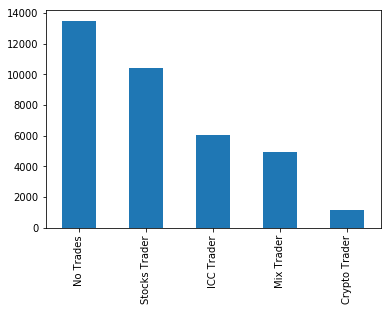

In [4]:
user_details['trading_segment'].value_counts().plot(kind='bar');

In [5]:
len(distinct_users)

36000

## Transactions entity

In [6]:
# # transactions entity
daily_transactions = transactions = pd.read_csv('data/cube_1y_6mCustomerValue_3kcohort.csv')
daily_transactions['date'] = pd.to_datetime(daily_transactions['date']) # , format="%m/%d/%y %H:%M")
daily_transactions = daily_transactions[daily_transactions.columns[1:]]
# daily_transactions = daily_transactions[daily_transactions['user_id'].isin(distinct_users)]
daily_transactions.reset_index(inplace=True,drop=True)
daily_transactions.reset_index(inplace=True)
daily_transactions.rename(columns={'index': 'transaction_id'}, inplace=True)
daily_transactions.head()

,transaction_id,user_id,date,trades_sb_invested_amount,financing_deposits_amount,trades_sb_short,trades_sb_long,view_position,trades_sb_open_positions,total_session_duration,education_topic_read,trades_fb_commission,trades_fb_forex_open,trades_sb_forex_open,conversion_to_sb,trades_fb_stocks_average_leverage,trades_sb_stocks_average_leverage,trades_sb_forex_average_leverage
0,0,00161196-a1cd-4661-b193-99b4414f3380,2017-08-21,0,0.0,0,0,0,0,1120,0,0.00,0,0,0,0.00,0.0,0.0
1,1,00161196-a1cd-4661-b193-99b4414f3380,2017-08-29,0,0.0,0,0,0,0,24,0,0.00,0,0,0,0.00,0.0,0.0
2,2,0018080e-36e9-4345-be84-baf2dfd99ca9,2017-08-16,0,0.0,0,0,61,0,1750,1,2.90,2,0,0,0.00,0.0,0.0
3,3,0018080e-36e9-4345-be84-baf2dfd99ca9,2017-08-17,0,0.0,0,0,455,0,10557,2,23.01,7,0,0,3.13,0.0,0.0
4,4,0018080e-36e9-4345-be84-baf2dfd99ca9,2017-08-18,0,0.0,0,0,22,0,560,1,4.06,0,0,0,2.00,0.0,0.0


### Calendar data (added to Transactions entity) - done in  SQL

In [7]:
# calendar_input = pd.DataFrame(daily_transactions.groupby('user_id').min()['date']).reset_index()
# calendar_input.head()
# calendar_df = pd.DataFrame()

# for index, row in calendar_input.iterrows():
#     temp_df = utils.create_date_range(row)
#     calendar_df = calendar_df.append(temp_df)

# calendar_df['date'] = pd.to_datetime(calendar_df['date'])
# len(calendar_df) / len(calendar_df['user_id'].unique())
# daily_transactions_merged = pd.merge(calendar_df, daily_transactions, on=['user_id', 'date'], how='left')
# len(daily_transactions_merged) / len(daily_transactions)
# daily_transactions = daily_transactions_merged

## Creating the entity set

In [8]:
es = ft.EntitySet("bux_cltv")

es.entity_from_dataframe(entity_id='users',
                    dataframe=user_details,
                    index='user_id',
                    time_index='bux_account_created_dts')

es.entity_from_dataframe(entity_id='transactions',
                    dataframe=daily_transactions,
                    index='transaction_id',
                    time_index='date')

es.add_relationship(ft.Relationship(es['users']['user_id'], es['transactions']['user_id']))

Entityset: bux_cltv
  Entities:
    transactions (shape = [214445, 18])
    users (shape = [36000, 13])
  Relationships:
    transactions.user_id -> users.user_id

### Remove the dfs from the memory

In [9]:
lst = [user_details, daily_transactions]
del user_details, daily_transactions
del lst

### Target values (whale / not whale)

In [10]:
label_data = pd.read_csv('data/curcv_1y_6mCustomerValue_3k.csv')
# label_data = label_data[label_data['user_id'].isin(distinct_users)]
label_data = label_data[label_data.columns[1:]]
label_data["label"] = label_data["com"] + label_data["ff"]
label_data = label_data[['user_id', 'label']]
label_data = label_data.fillna(0)

# whale_threshold = label_data["label"].quantile(0.99)
whale_threshold = 50
label_data["curcv"] = label_data["label"]
label_data["label"] = (label_data['curcv'] > whale_threshold).astype(int)

In [11]:
label_data['label'].value_counts()

0    35603
1      397
Name: label, dtype: int64

In [12]:
# trying different primitives for DFS:
# 1. agg: Trend, Skew, Median)
# 2. trans: Day, Hour, Minute, Month, Weekday, Week, Weekend

In [44]:
%%time
# Adding agg. primitives: Trend, Median & Skew -> Wall time: 1h 22min 57s (no improvement of performance)
# Adding trans. primitives: Day, Week, Month, Weekday, Weekend -> Wall time: 12min 58s (improvement of performance)

from featuretools.primitives import (Sum, Std, Max, Min, Mean,
                                 Count, PercentTrue, NUnique, 
                                 Day, Week, Month, Weekday, Weekend)


trans_primitives = [Day, Week, Month, Weekday, Weekend]
agg_primitives = [Sum, Std, Max, Min, Mean, Count, PercentTrue, NUnique]


feature_matrix, features = ft.dfs(
    entityset=es,
    target_entity="users",
    trans_primitives=trans_primitives,
    agg_primitives=agg_primitives,
    max_depth=2,
    verbose=True
)

print("{} features generated".format(len(features)))

fm_encoded, features_encoded = ft.encode_features(feature_matrix, features)

X = fm_encoded.reset_index().merge(label_data)

Building features: 132it [00:00, 2042.00it/s]
Progress:   0%|          | 0/1 [00:00<?, ?cutoff time/s]

KeyboardInterrupt: 

In [14]:
# drop after rerunning DFS again
X.drop(['user_id', 'curcv'], axis=1, inplace=True)
X = X.fillna(0)
y = X.pop('label').astype('int')
y.value_counts()

0    35603
1      397
Name: label, dtype: int64

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## XGBooster

In [17]:
params = {
        'min_child_weight': 1,
        'eta': 0.166,
        'colsample_bytree': 0.4,
        'max_depth': 9,
        'sub_sample': 1.0,
        'lambda': 57.93,
        'booster': 'gbtree',
        'gamma': 0.5,
        'silent':1,
        'eval_metric': 'auc',
        'objective': 'binary:logistic',

    }

xgb_model = utils.train_xgb(X_train, y_train, params)

[0]	train-auc:0.82151	valid-auc:0.846627
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 60 rounds.
[10]	train-auc:0.994615	valid-auc:0.995288
[20]	train-auc:0.995588	valid-auc:0.995388
[30]	train-auc:0.996376	valid-auc:0.995431
[40]	train-auc:0.996748	valid-auc:0.995443
[50]	train-auc:0.997316	valid-auc:0.995467
[60]	train-auc:0.997745	valid-auc:0.995473
[70]	train-auc:0.997933	valid-auc:0.9954
Stopping. Best iteration:
[18]	train-auc:0.995483	valid-auc:0.995588

Modeling AUC 0.99559


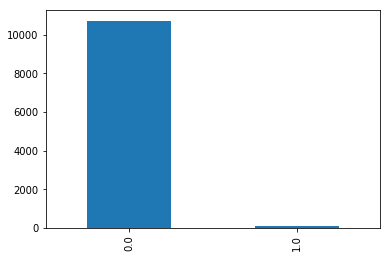

In [54]:
y_pred_xgb = utils.predict_xgb(xgb_model, X_test)
pd.Series(y_pred_xgb.round(0)).value_counts().plot(kind='bar');

In [56]:
f1_score(y_test, y_pred_xgb.round(0), average=None)[1]

0.59813084112149528

In [62]:
y_pred_round_xgb = [1 if value > 0.5 else 0 for value in y_pred_xgb]

precision, recall, fscore, support = score(y_test, y_pred_round_xgb)

print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('Fscore: {}'.format(fscore))
print('Support: {}'.format(support))

Precision: [ 0.9931922   0.83116883]
Recall: [ 0.99878083  0.46715328]
Fscore: [ 0.99597868  0.59813084]
Support: [10663   137]


In [63]:
y_pred_round_xgb = [1 if value > 0.2 else 0 for value in y_pred_xgb]

precision, recall, fscore, support = score(y_test, y_pred_round_xgb)

print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('Fscore: {}'.format(fscore))
print('Support: {}'.format(support))

Precision: [ 0.99651404  0.53763441]
Recall: [ 0.99193473  0.72992701]
Fscore: [ 0.99421911  0.61919505]
Support: [10663   137]


In [71]:
y_pred_round_xgb = [1 if value > 0.1 else 0 for value in y_pred_xgb]

precision, recall, fscore, support = score(y_test, y_pred_round_xgb)

print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('Fscore: {}'.format(fscore))
print('Support: {}'.format(support))

Precision: [ 0.99885812  0.42955326]
Recall: [ 0.98443215  0.91240876]
Fscore: [ 0.99159267  0.58411215]
Support: [10663   137]


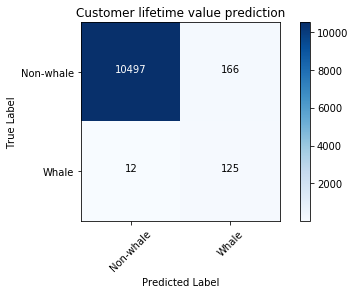

In [72]:
cm = confusion_matrix(y_test, y_pred_round_xgb)
utils.plot_confusion_matrix(cm, ['Non-whale', 'Whale'], title='Customer lifetime value prediction')

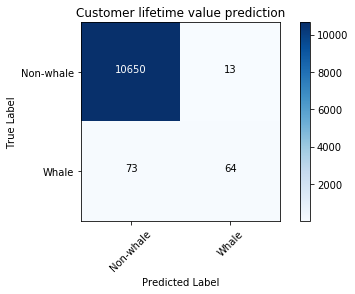

In [73]:
cm = confusion_matrix(y_test, y_pred_xgb.round(0))
utils.plot_confusion_matrix(cm, ['Non-whale', 'Whale'], title='Customer lifetime value prediction')

In [74]:
feature_names = X_train.columns.values
ft_importances = utils.feature_importances_xgb(xgb_model, feature_names)
ft_importances[0:10]

,feature_name,importance
27,initial_deposit_amount,37.0
22,MEAN(transactions.trades_sb_invested_amount),27.0
37,SUM(transactions.trades_sb_invested_amount),25.0
1,SUM(transactions.trades_fb_stocks_average_leve...,24.0
54,SUM(transactions.view_position),23.0
4,STD(transactions.education_topic_read),23.0
81,SUM(transactions.total_session_duration),23.0
78,SUM(transactions.education_topic_read),20.0
32,STD(transactions.trades_fb_stocks_average_leve...,19.0
50,COUNT(transactions),19.0


In [75]:
"""

There are in general two ways that you can control overfitting in xgboost :

The first way is to directly control model complexity◦This include max_depth, min_child_weight and gamma
The second way is to add randomness to make training robust to noise◦This include subsample, colsample_bytree
You can also reduce stepsize eta, but needs to remember to increase num_round when you do so

"""

'\n\nThere are in general two ways that you can control overfitting in xgboost :\n\nThe first way is to directly control model complexity◦This include max_depth, min_child_weight and gamma\nThe second way is to add randomness to make training robust to noise◦This include subsample, colsample_bytree\nYou can also reduce stepsize eta, but needs to remember to increase num_round when you do so\n\n'

In [76]:
# n_folds = 5
# early_stopping = 10
# xg = xgb.DMatrix(X, label=y)

# cv = xgb.cv(params, xg, 5000, nfold=n_folds, early_stopping_rounds=early_stopping, verbose_eval=1)

In [77]:
# top_features = utils.feature_importances(xgb_model, features_encoded, n=20)
# ft.save_features(top_features, "top_features_xgb_time")

In [78]:
# drop after rerunning DFS again
# X.drop(['user_id', 'curcv'], axis=1, inplace=True)
# X = X.fillna(0)
# y = X.pop('label').astype('int')
# y.value_counts()

### Random Forest classifier

In [82]:
pd.Series(y_pred_xgb.round(0)).value_counts()

0.0    10723
1.0       77
dtype: int64

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=400, n_jobs=-1)
rf_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [84]:
X_test.head()

,title = Rookie Trader,title = Experienced Trader,title = Pro Trader,title = PRO Trader,title = Channel Owner,title = unknown,network = Facebook Installs,network = Organic,network = Viral Invites,network = TV,...,STD(transactions.trades_fb_forex_open),MIN(transactions.education_topic_read),MEAN(transactions.trades_sb_short),MAX(transactions.education_topic_read),MIN(transactions.trades_sb_long),STD(transactions.financing_deposits_amount),MEAN(transactions.trades_sb_stocks_average_leverage),MAX(transactions.total_session_duration),MIN(transactions.view_position),MAX(transactions.financing_deposits_amount)
16461,1,0,0,0,0,0,0,0,0,1,...,1.343710,0.0,0.0,2.0,0.0,0.000000,0.000000,926.0,0.0,0.0
23579,0,1,0,0,0,0,0,0,0,1,...,0.000000,1.0,0.0,1.0,0.0,0.000000,0.000000,198.0,2.0,0.0
23640,1,0,0,0,0,0,0,0,0,1,...,0.458123,0.0,0.0,9.0,0.0,22.906142,0.111111,2403.0,0.0,100.0
25635,1,0,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,1123.0,0.0,0.0
8840,1,0,0,0,0,0,1,0,0,0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,617.0,12.0,0.0


In [110]:
y_pred_rf = rf_clf.predict_proba(X_test)
y_pred_rf = pd.Series([value[1] for value in y_pred_rf])

In [116]:
f1_score(pd.Series(y_test), y_pred_rf.round(0), average=None)[1]

0.54726368159203986

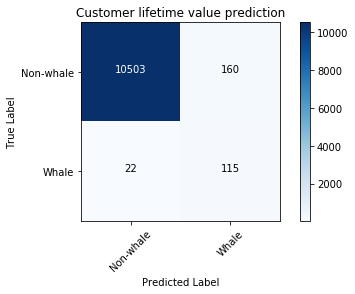

In [119]:
y_pred_rf_rounded = [1 if value > 0.1 else 0 for value in y_pred_rf]

cm = confusion_matrix(y_test, y_pred_rf_rounded)
utils.plot_confusion_matrix(cm, ['Non-whale', 'Whale'], title='Customer lifetime value prediction')

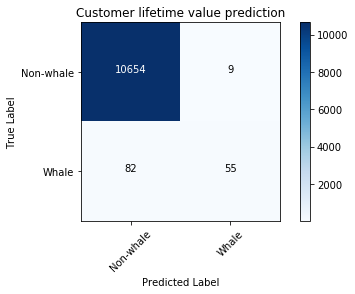

In [120]:
cm = confusion_matrix(y_test, y_pred_rf.round(0))
utils.plot_confusion_matrix(cm, ['Non-whale', 'Whale'], title='Customer lifetime value prediction')

In [121]:
# random forest classifer, 5-fold cross-validation
# https://datascience.stackexchange.com/questions/6510/does-modeling-with-random-forests-requre-cross-validation
scores = cross_val_score(estimator=rf_clf, X=X, y=y, scoring='f1', verbose=True, cv=5, n_jobs=-1)
"F1 %.2f +/- %.2f" % (scores.mean(), scores.std())

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


'F1 0.54 +/- 0.07'

In [122]:
# calculate the top 20 features based on feature importance
top_features = utils.feature_importances(rf_clf, features_encoded, n=20)
ft.save_features(top_features, "top_features_time")

1: Feature: <Feature: initial_deposit_amount>, 0.081
2: Feature: <Feature: STD(transactions.trades_sb_invested_amount)>, 0.039
3: Feature: <Feature: MAX(transactions.trades_sb_invested_amount)>, 0.039
4: Feature: <Feature: SUM(transactions.trades_sb_invested_amount)>, 0.036
5: Feature: <Feature: MEAN(transactions.trades_sb_invested_amount)>, 0.036
6: Feature: <Feature: SUM(transactions.financing_deposits_amount)>, 0.033
7: Feature: <Feature: MAX(transactions.financing_deposits_amount)>, 0.024
8: Feature: <Feature: SUM(transactions.view_position)>, 0.023
9: Feature: <Feature: STD(transactions.financing_deposits_amount)>, 0.022
10: Feature: <Feature: MEAN(transactions.view_position)>, 0.022
11: Feature: <Feature: SUM(transactions.total_session_duration)>, 0.020
12: Feature: <Feature: SUM(transactions.trades_sb_open_positions)>, 0.019
13: Feature: <Feature: MEAN(transactions.total_session_duration)>, 0.018
14: Feature: <Feature: SUM(transactions.trades_sb_stocks_average_leverage)>, 0.017


## Iteration 2 (Parallelized, retrain with top 20 features)

In [28]:
path = "partitioned_data_chunks"
_, dirnames, _ = os.walk(path).__next__()
dirnames = [path+d for d in dirnames]
b = bag.from_sequence(dirnames)
entity_sets = b.map(utils.load_entity_set)

In [29]:
labels = entity_sets.map(utils.make_labels)
labels

dask.bag<map-mak..., npartitions=4>

In [30]:
# train the classifier with the top features
top_features = ft.load_features("top_features", es)
feature_matrices = labels.map(utils.calculate_feature_matrix_top_features, features=top_features)

In [31]:
fms_out  = feature_matrices.compute()
X = pd.concat(fms_out)

[                                        ] | 0% Completed |  1min 53.2s


KeyError: 'trading_segment'

In [ ]:
X.drop(['user_id', 'curcv', 'time'], axis=1, inplace=True)
X = X.fillna(0)
y = X.pop('label').astype('int')
y.value_counts()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=400, n_jobs=-1) # class_weight='balanced')
rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_test)
f1_score(y_test, y_pred, average=None)[1]

In [ ]:
cm = confusion_matrix(y_test, y_pred)
utils.plot_confusion_matrix(cm, ['Non-whale', 'Whale'], title='Customer lifetime value prediction')

In [ ]:
# random forest classifer, 5-fold cross-validation
scores = cross_val_score(estimator=rf_clf, X=X, y=y, scoring='f1', verbose=True, cv=5, n_jobs=-1)
"F1 %.2f +/- %.2f" % (scores.mean(), scores.std())

In [ ]:
precision, recall, fscore, support = score(y_test, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

In [ ]:
scores

In [ ]:
top_features = utils.feature_importances(rf_clf, features_encoded, n=20)

## XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
from xgboost import XGBClassifier

In [ ]:
ratio = y.value_counts()[0] / len(y)
params['scale_pos_weight'] = ratio

In [ ]:
xgb_clf = XGBClassifier(scale_pos_weight=ratio)
xgb_clf.fit(X_train, y_train)

In [ ]:
y_pred_xgb = xgb_clf.predict(X_test)
y_pred_xgb = [round(value) for value in y_pred_xgb]

In [ ]:
f1_score(y_test, y_pred_xgb, average=None)[1]

In [ ]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 1,
    'silent': 1,
    'eta': 1
}

num_rounds = 15


In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

In [ ]:
# bst = booster
bst = xgb.train(params, dtrain, num_rounds)
y_pred_xgb = (bst.predict(dtest) > 0.5).astype(int)

## SMOTE (oversampling)

1. Collect more data
2. Use better evaluation metric (AUC, F1, Kappa...)
3. Generate artificial samples of minority class (e.g. SMOTE algorithm)

In XGBoost:
    - set a small min_child_weight (leaf nodes can have smaller size groups)
    - assign more weights to specific samples while initializing DMatrix
    - control the balance to positive and negative weights using set_post weight parameter
    - use AUC for evaluation
    

### Generate artificial samples of minority class

In [ ]:
# https://elitedatascience.com/imbalanced-classes
# https://chrisalbon.com/machine_learning/trees_and_forests/handle_imbalanced_classes_in_random_forests/
# https://blog.dominodatalab.com/imbalanced-datasets/


# https://beckernick.github.io/oversampling-modeling/

sm = SMOTE(random_state=100, ratio = 1)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [ ]:
pd.Series(y_train_res).value_counts()

In [ ]:
%%time

clf_smote = RandomForestClassifier(n_estimators=25, random_state=12)
clf_smote.fit(X_train_res, y_train_res)

In [ ]:
y_pred_smote = clf_smote.predict(X_test)
y_pred_smote

In [ ]:
cm = confusion_matrix(y_test, y_pred_smote)
utils.plot_confusion_matrix(cm, ['Non-whale', 'Whale'], title='Customer lifetime value prediction')

In [ ]:
# f1 score with SMOTE
f1_score(y_test, y_pred_smote, average=None)[1]

In [ ]:
top_features = utils.feature_importances(clf_smote, features_encoded, n=20)
top_features

In [ ]:
precision, recall, fscore, support = score(y_test, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

In [ ]:
%%time

clf_cv = RandomForestClassifier(n_estimators=400, n_jobs=-1)
scores = cross_val_score(estimator=clf_cv, X=X, y=y, scoring='f1', verbose=True, cv=5)
print("F1 score %.2f +/- %.2f" % (scores.mean(), scores.std()))

In [ ]:
scores

In [ ]:
clf_cv = RandomForestClassifier(n_estimators=400, n_jobs=-1)
scores = cross_val_score(estimator=clf_cv, X=X, y=y, scoring='precision', verbose=True, cv=5)
print("Precision score %.2f +/- %.2f" % (scores.mean(), scores.std()))

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score


y_pred_proba = clf.predict_proba(X_test)
average_precision = average_precision_score(y_test, y_pred)
pr, re, _ = precision_recall_curve(y_test,y_pred,pos_label=1)


plt.step(re, pr, color='b', alpha=0.2,
         where='post')
plt.fill_between(re, pr, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [ ]:
clf_cv.decision_path(X_test)

## Regression

In [ ]:
X = fm.reset_index().merge(CurCV[['user_id', 'curcv']])
X = X.fillna(0)
X.drop(["user_id", "time"], axis=1, inplace=True)
y = X.pop("curcv")

In [ ]:
len(X.columns)

In [ ]:
# average customer value
y.mean()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
y_train.describe()

In [ ]:
y_test.describe()

In [ ]:
regr = RandomForestRegressor(max_depth=2, random_state=0)

In [ ]:
%%time


regr.fit(X_train, y_train)

In [ ]:
utils.feature_importances(regr, features_encoded, n=20)

In [ ]:
y_pred = regr.predict(X_test)

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [ ]:
y_test.head()

In [ ]:
r2_reg = r2_score(y_test, y_pred).round(3)
r2_reg

In [ ]:
print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(np.sqrt(mean_squared_error(y_test, y_pred)))

In [ ]:
test_set_pred = sum(y_pred)
test_set_true = sum(y_test)

test_set_pred, test_set_true

In [ ]:
test_set_benchmark = len(y_test) * CurCV['curcv'].mean()

test_set_benchmark, test_set_true

In [ ]:
y_benchmark = [CurCV['curcv'].mean() for i in range(0,len(y_test))]

In [ ]:
print(mean_absolute_error(y_test, y_benchmark))
print(mean_squared_error(y_test, y_benchmark))
print(np.sqrt(mean_squared_error(y_test, y_benchmark)))